In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

guns = pd.read_csv("GunDeaths.csv", index_col=0)

Let peak into our data

In [196]:
print(guns.shape)
guns.head()

(100798, 10)


,year,month,intent,police,sex,age,race,hispanic,place,education
1,2012,1,Suicide,0,M,34.0,Asian/Pacific Islander,100,Home,4.0
2,2012,1,Suicide,0,F,21.0,White,100,Street,3.0
3,2012,1,Suicide,0,M,60.0,White,100,Other specified,4.0
4,2012,2,Suicide,0,M,64.0,White,100,Home,4.0
5,2012,2,Suicide,0,M,31.0,White,100,Other specified,2.0


So we have 10 columns and over 10k datapoints. Let's give a description of the columns:
1. Year: year when incident occured
2. Month: month when incident occured
3. Intent: intent of the crime via the perpetrator, can be:
    + Suicide
    + Accidental
    + NA
    + Homicide
    + Undetermined
4. Police: whether the police were involved in the shooting or not
5. Sex: victim's gender
6. Age: victim's age
7. Race: victim's race, can be:
    + Asian/Pacific Islander 
    + Native American/Native Alaskan 
    + Black 
    + Hispanic 
    + White
8. Hispanic: hispanic origin code from CDC, can find lookup here:
    + https://www.cdc.gov/nchs/data/dvs/Appendix_D_Accessible_Hispanic_Origin_Code_List_Update_2011.pdf
9. Place: where shooting occured
10. Education: victim's education, can be:
    + 1- Less than High School
    + 2- Graduated from High School or equivalent
    + 3- Some College 
    + 4- At least graduated from College
    + 5- Not available

Let's check for how complete the data is

In [197]:
guns.notnull().sum() * (100/guns.shape[0])

year         100.000000
month        100.000000
intent        99.999008
police       100.000000
sex          100.000000
age           99.982143
race         100.000000
hispanic     100.000000
place         98.626957
education     99.947420
dtype: float64

Since our data is extremely large and we aren't missing many datapoints, we will just remove points that have anything null in it.  Will only lose ~1% of data

In [198]:
guns = guns.dropna(axis=0, how="any")

Just looking at the columns, the most interesting column to predict will probably be intent.  So that is what we will aim for.  That being said we can remove any columns that have intent as undetermined

In [199]:
guns = guns[guns.intent != "Undetermined"]

Month and Year are separate, not sure why.. let's take a look at them to see if anything stands out

In [200]:
print(guns.month.value_counts(sort=False))
print(guns.year.value_counts(sort=False))

1     8081
2     6950
3     8101
4     8255
5     8466
6     8464
7     8790
8     8570
9     8318
10    8245
11    8052
12    8245
Name: month, dtype: int64
2012    32816
2013    32865
2014    32856
Name: year, dtype: int64


The only thing that stands out is there is less deaths in February, but I am nearly positive that is because of it being a shorter month.  Because the rest is relatively evenly distributed at first glance, we will combine month and year

In [201]:
from datetime import datetime
guns["date"] = guns.apply(lambda row: datetime(row.year, row.month, 1), axis=1)
del guns["year"]
del guns["month"]

# while I'm here just gonna make police into a boolean for readability 
guns.police = guns.police.astype(bool)

In [202]:
guns.head()

,intent,police,sex,age,race,hispanic,place,education,date
1,Suicide,False,M,34.0,Asian/Pacific Islander,100,Home,4.0,2012-01-01
2,Suicide,False,F,21.0,White,100,Street,3.0,2012-01-01
3,Suicide,False,M,60.0,White,100,Other specified,4.0,2012-01-01
4,Suicide,False,M,64.0,White,100,Home,4.0,2012-02-01
5,Suicide,False,M,31.0,White,100,Other specified,2.0,2012-02-01


I'm gonna start visualizing some of the data on things that I think might be interesting and tell us some stuff; starting with Intent and whether or not the police were involved or not

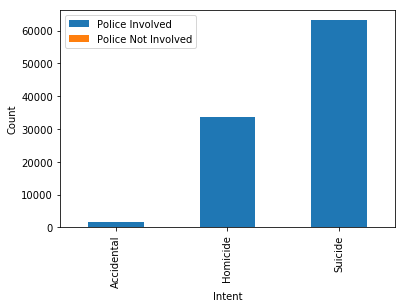

In [203]:
intentAndPolice = guns.groupby([guns.intent, guns.police]).intent.count().unstack('police')
plot = intentAndPolice.plot(kind="bar", stacked=True)
plot.legend(labels=["Police Involved", "Police Not Involved"])
plot.set_xlabel("Intent")
plot.set_ylabel("Count")
plt.show()

In [204]:
intentAndPolice

police,False,True
intent,,
Accidental,1625.0,NaN
Homicide,33731.0,19.0
Suicide,63162.0,NaN


So our bar graph didn't tell us much because police were only involved with 19 shootings, BUT all 19 dealt with homocides.  This will come in useful when making your model

Let's look at the age distributions and intent

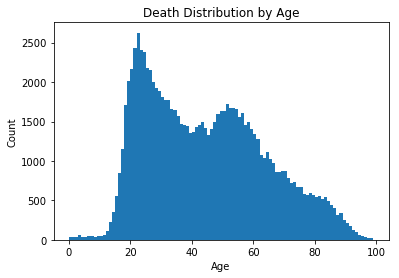

In [205]:
plt.hist(guns.age, range(0, 100))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Death Distribution by Age")
plt.show()

Looking at this two things stand out, the bump in the 20s and the bump between about 50-60.  I will take a guess that the 20s would be homicides and the 50-60 bump would be suicides.  I would also guess that accidental will be that small number below the 20s

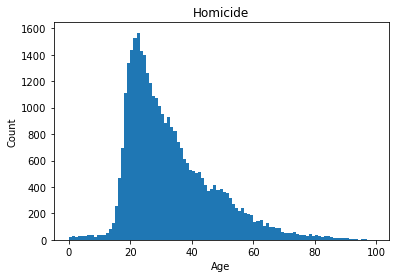

In [206]:
plt.hist(guns.age[guns.intent == "Homicide"], range(0, 100))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Homicide")
plt.show()

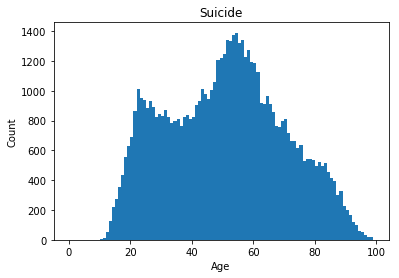

In [207]:
plt.hist(guns.age[guns.intent == "Suicide"], range(0, 100))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Suicide")
plt.show()

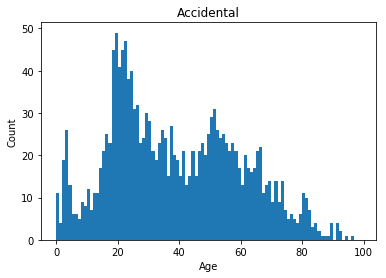

In [208]:
plt.hist(guns.age[guns.intent == "Accidental"], range(0, 100))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Accidental")
plt.show()

So it looks like I was correct about homicide and suicide given the age groups, but I was wrong about accidental deaths, which for the most part seems to be rather scattered

Now let's look at Intent vs Sex

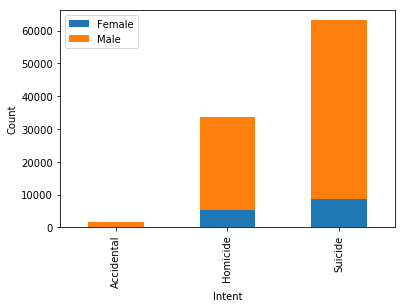

In [209]:
intentAndSex = guns.groupby([guns.intent, guns.sex]).intent.count().unstack('sex')
plot = intentAndSex.plot(kind="bar", stacked=True)
plot.legend(labels=["Female", "Male"])
plot.set_xlabel("Intent")
plot.set_ylabel("Count")
plt.show()

In [210]:
intentAndSex

sex,F,M
intent,,
Accidental,215,1410
Homicide,5293,28457
Suicide,8687,54475


As expected, males dramatically outweight women in all incidents.  There is no large distinction between determining if a women was involved with suicide or homicide.  Hopefully we can find this elsewhere

Let's now look at the victim's race and see if we can find any information from this 

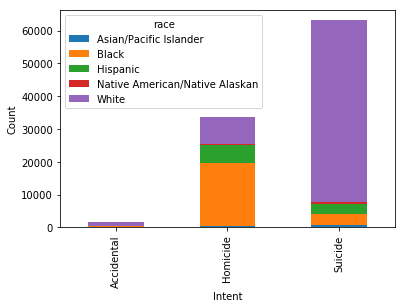

In [211]:
intentAndRace = guns.groupby([guns.intent, guns.race]).intent.count().unstack('race')
plot = intentAndRace.plot(kind="bar", stacked=True)
plot.set_xlabel("Intent")
plot.set_ylabel("Count")
plt.show()

In [212]:
intentAndRace

race,Asian/Pacific Islander,Black,Hispanic,Native American/Native Alaskan,White
intent,,,,,
Accidental,12,321,145,21,1126
Homicide,527,19145,5348,300,8430
Suicide,745,3331,3169,554,55363


Since accidental is rather disproportionate to homicide and suicide we should look at this in percentages 

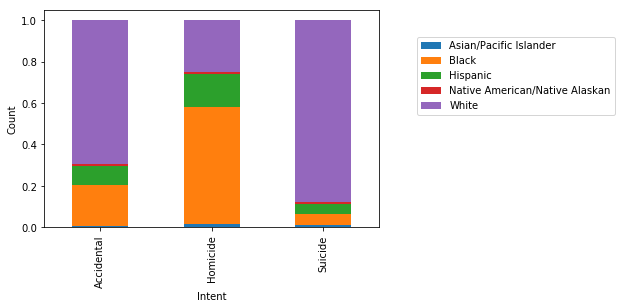

In [213]:
intentAndRace = intentAndRace.div(intentAndRace.sum(1).astype(float), axis=0)
plot = intentAndRace.plot(kind="bar", stacked=True)
plot.set_xlabel("Intent")
plot.set_ylabel("Count")
plt.legend(bbox_to_anchor=(1.1,0.9))
plt.show()

That's better, now we can see that whites are the main victims of suicide by a long shot; same goes for accidental deaths, but not as much.  We can also see that blacks are suffer significantly more than any race in homocides

Looking at the race distibutions, the hispanic field might not be worth really looking at, let's take a quick look at the value counts

In [214]:
guns.hispanic.value_counts() * (100/guns.hispanic.shape[0])

100    90.916103
210     5.312725
260     0.827100
270     0.421162
282     0.377523
281     0.338959
998     0.293291
211     0.263860
220     0.211088
226     0.169479
275     0.168465
261     0.124826
222     0.112648
223     0.108589
280     0.074084
234     0.046683
250     0.035520
224     0.028416
235     0.022327
200     0.018267
271     0.018267
237     0.018267
227     0.016238
225     0.013193
239     0.012178
231     0.010148
291     0.009134
233     0.007104
232     0.006089
242     0.004059
299     0.003045
221     0.003045
286     0.002030
217     0.001015
218     0.001015
212     0.001015
238     0.001015
209     0.001015
252     0.001015
Name: hispanic, dtype: float64

Whelp that feature is pretty worthless, > 90% of the victims weren't even hispanic! So we will just remove that column

In [215]:
del guns["hispanic"]

In [216]:
guns.head()

,intent,police,sex,age,race,place,education,date
1,Suicide,False,M,34.0,Asian/Pacific Islander,Home,4.0,2012-01-01
2,Suicide,False,F,21.0,White,Street,3.0,2012-01-01
3,Suicide,False,M,60.0,White,Other specified,4.0,2012-01-01
4,Suicide,False,M,64.0,White,Home,4.0,2012-02-01
5,Suicide,False,M,31.0,White,Other specified,2.0,2012-02-01


Let's take a look at Intent vs Place

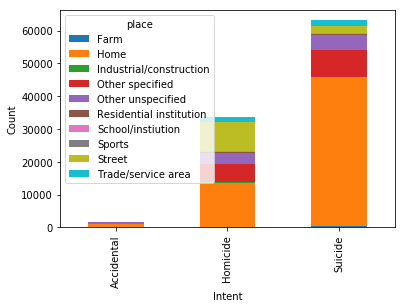

In [217]:
intentAndPlace = guns.groupby([guns.intent, guns.place]).intent.count().unstack('place')
plot = intentAndPlace.plot(kind="bar", stacked=True)
plot.set_xlabel("Intent")
plot.set_ylabel("Count")
plt.show()

Again, pretty disproportionate, so lets make them percentages again.  But it is worthy to note that suicide seems to occur in the home most of the time

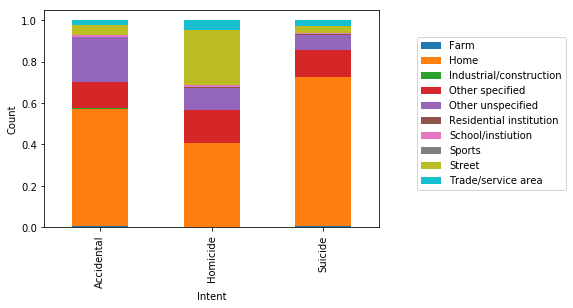

In [218]:
intentAndPlace = intentAndPlace.div(intentAndPlace.sum(1).astype(float), axis=0)
plot = intentAndPlace.plot(kind="bar", stacked=True)
plot.set_xlabel("Intent")
plot.set_ylabel("Count")
plt.legend(bbox_to_anchor=(1.1,0.9))
plt.show()

So we can see that there is a lot of data here that looks like it might distract our model.  There are only 5 options that really stand out: Home, Other specified, Other unspecified, Street, and Trade/service area.  And among those, Other specified and Other unspecified tell us absolutely nothing and could potentially throw off our model.  Trade/service area also is pretty evenly distributed and doesn't tell us too much, so I think what will be best is to just keep Home and Street then replace the rest with 'Other'

In [219]:
indexOfOthers = guns[(guns.place != "Home") & (guns.place != "Street")].index
guns.loc[indexOfOthers, "place"] = "Other"

Now let's look again

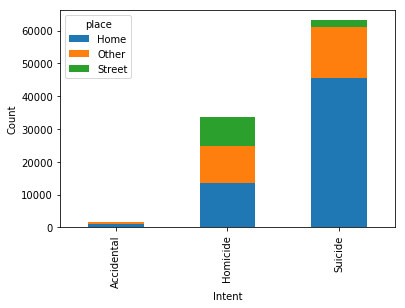

In [220]:
intentAndPlace = guns.groupby([guns.intent, guns.place]).intent.count().unstack('place')
plot = intentAndPlace.plot(kind="bar", stacked=True)
plot.set_xlabel("Intent")
plot.set_ylabel("Count")
plt.show()

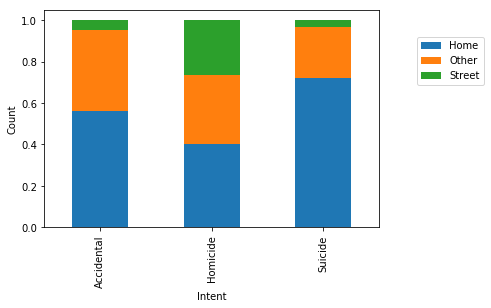

In [221]:
intentAndPlace = intentAndPlace.div(intentAndPlace.sum(1).astype(float), axis=0)
plot = intentAndPlace.plot(kind="bar", stacked=True)
plot.set_xlabel("Intent")
plot.set_ylabel("Count")
plt.legend(bbox_to_anchor=(1.1,0.9))
plt.show()

Much better.  This still doesn't tell us a whole lot but we can derive that there are strong possibilities of 2 things: if incedent occured at home then there is a high chance it was a suicide and if incedent occured in the streets then there is a high chance of it being a homicide 

And finally, let's look at education

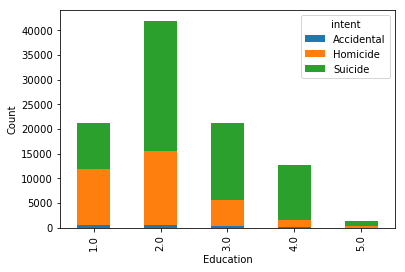

In [222]:
intentAndEducation = guns.groupby([guns.intent, guns.education]).intent.count().unstack('intent')
plot = intentAndEducation.plot(kind="bar", stacked=True)
plot.set_xlabel("Education")
plot.set_ylabel("Count")
plt.show()

The only thing I can gather from this is that is seems that there seems to be a lot of suicides when the victim has graduated from high school (2.0).  It is not signifcant but it is something

I want to look at one more thing before building my model.  I want to see if there is anything with Month vs Intent.  Since I previously combined month and year, I will just reload the dataframe.  I will also get rid of year because that doesn't seem to tell us anything at all.


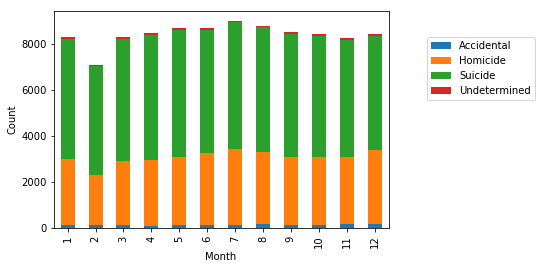

In [223]:
guns = pd.read_csv("GunDeaths.csv", index_col=0)

intentAndMonth = guns.groupby([guns.intent, guns.month]).intent.count().unstack('intent')
plot = intentAndMonth.plot(kind="bar", stacked=True)
plt.legend(bbox_to_anchor=(1.1,0.9))
plot.set_xlabel("Month")
plot.set_ylabel("Count")
plt.show()

Ok, so there doesn't seem to be anything of substance here.  The only thing that could be said is in July, there are slightly more homicides and suicides. But nothing substantial.

So before building my model there are a few things that I will need to do to prep my data given my analysis:
1. Month and year features can be removed 
    + Removing month because even though July has a little bit higher levels, February has significantly lower levels which
2. Get rid of hispanic feature
    + Over 90% rows weren't even hispanic, so this feature is worthless in my opinion
3. Get rid of data not that have any null data
    + We have a large dataset and it is mostly complete, so we can afford to clean this up
4. Remove "Undetermined" intents
    + Since we are predicting intent, this doesn't help us
 could throw off the model.  I am almost positive this is because of the shorter month so better safe than sorry and remove
5. For places, should only keep Home and Street; the rest can be combined in "Other"

Now we can build a model, see GunDeathPredictor.py